# Aim of the notebook
This notebook is made for the Capstone Project of the Data Science Intensive Course at Springboard.

## Capstone Project
The project focuses on the Caltech256 data set. (Source: http://www.vision.caltech.edu/Image_Datasets/Caltech256/)<br>
Goal is to classify 256 different object categories.

## Approach
1. Analyze the dataset
2. Choose a proper model based on the analysis
3. Train the model
4. Improve model
5. Submit

## 1. Analyze the dataset
- Overview about the data.
- Check how the images look.
- Check how many training examples are aviable for each class
- Check the size of the images.
- Check the RGB - Values of different classes.

In [298]:
# import libraries
import matplotlib.pyplot as plt
from IPython.display import Image
from collections import Counter
import PIL as pil
import os as os
import numpy as np
import pandas as pd
import cv2
import seaborn as sns

%matplotlib inline

#### Overview about the data.
The data contains 256 different classes

#### Check how the images look.

The following images show some randomly choosen images of the dataset, in different categories.

AK47

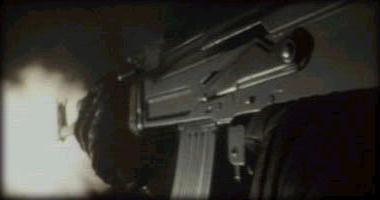

In [2]:
Image(data='data/001.ak47/001_0005.jpg')

Brain

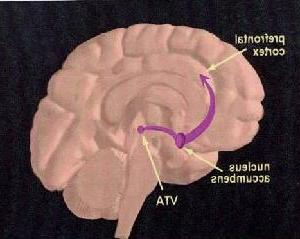

In [3]:
Image(data='data/020.brain-101/020_0064.jpg')

Breadmaker

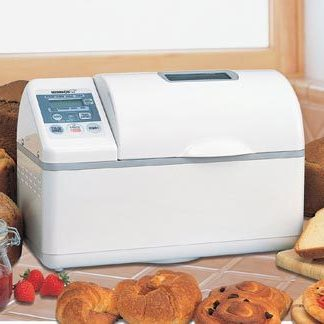

In [4]:
Image(data='data/021.breadmaker/021_0030.jpg')

IPod

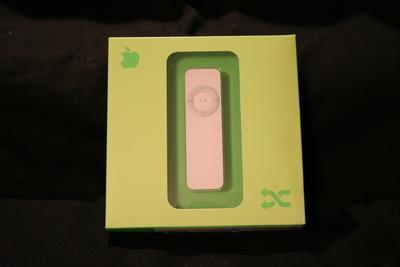

In [5]:
Image(data='data/117.ipod/117_0029.jpg')

Leopard

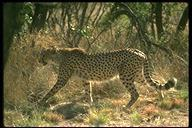

In [6]:
Image(data='data/129.leopards-101/129_0012.jpg')

#### Check how many training examples are aviable for each class

In [7]:
# returns the amount of files with a specific extension
def count_files(path, extension=".jpg"):
    count = 0
    for file in os.listdir(path):
        if file.endswith(extension):
            count += 1
    return count

In [8]:
# returns a pandas Dataframe with two columns, containg folder name and the amount of files for that folder
def files_per_folder(path, extension=".jpg"):
    df = pd.DataFrame(columns=["folder", "count"])
    for file in os.listdir(path):
        child = os.path.join(path, file)
        if os.path.isdir(child):
            count = count_files(child, extension)
            df = df.append({
                "folder": file,
                "count": count
            }, ignore_index=True)
    return df

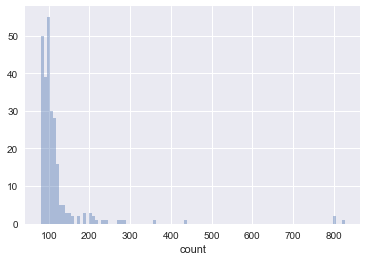

In [9]:
classes = files_per_folder("data")
sns.distplot(classes["count"], 100, kde=False)

In [10]:
sample_count = classes['count']
print("Mean: ", round(sample_count.mean()))
print("Min: ", sample_count.min())
print("Max: ", sample_count.max())

Mean:  119.0
Min:  80.0
Max:  827.0


We have on average about 119 training examples, on some classes have more than 800 samples.

#### Check the size of the images.

In [11]:
# lists the occurences of image resolutions in a directory
def image_resolution_occurance(path):
    sizes = {}
    for file in os.listdir(path):
        if file.endswith("jpg"):
            child = os.path.join(path, file)
            im = pil.Image.open(child)
            try:
                sizes[im.size] += 1
            except:
                sizes[im.size] = 1
    return sizes

In [12]:
# count the occurances of each resolution in a path
def image_resolution_occurance_multi(path):
    occ = Counter({})
    for file in os.listdir(path):
        child = os.path.join(path, file)
        if os.path.isdir(child):
            sizes = image_resolution_occurance(child)
            occ += Counter(sizes)
    return occ

In [13]:
occurrances = image_resolution_occurance_multi("data")

In [14]:
occurrances = pd.DataFrame.from_dict(occurrances, orient='index').reset_index()
occurrances.columns = ["res", "occ"]
occurrances.head()

,res,occ
0,"(180, 313)",1
1,"(399, 217)",1
2,"(280, 261)",2
3,"(350, 617)",1
4,"(261, 216)",1


In [15]:
len(occurrances)

15423

We see that we have 15423 different image resoultions. We try to find an average resoultion we can scale our other images to.

In [16]:
# split width and height - tuple in seperate columns
occurrances[['width', 'height']] = occurrances['res'].apply(pd.Series)
occurrances.head()

,res,occ,width,height
0,"(180, 313)",1,180,313
1,"(399, 217)",1,399,217
2,"(280, 261)",2,280,261
3,"(350, 617)",1,350,617
4,"(261, 216)",1,261,216


In [17]:
# mean width
round(occurrances["width"].mean())

382.0

In [18]:
# mean height
round(occurrances["height"].mean())

345.0

We will now rezise all images on the same resolution, and we will try to find someting in the RGB - Channels in the different classes. Later in traing our model we will maybe use the full image size but at the moment we want to get an overview about the data.

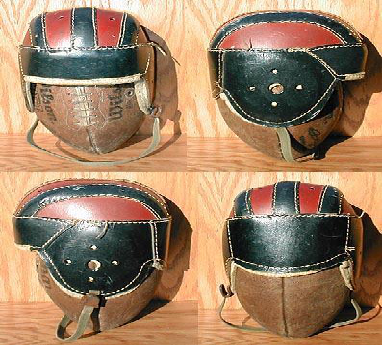

In [19]:
im = pil.Image.open("data/076.football-helmet/076_0016.jpg")
im.resize((382, 345))

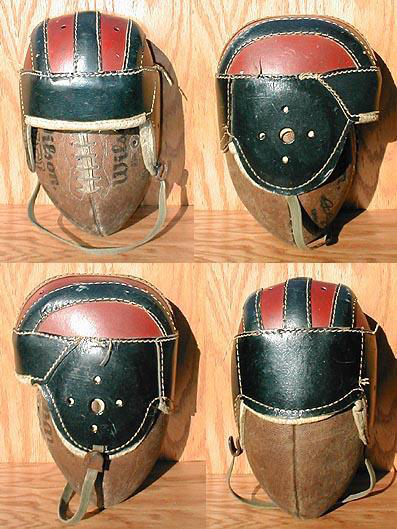

In [24]:
im

In [124]:
# resize all images in a given path and stores it in a given path
def resize_in_path(path_s, path_t, width, height):
    os.mkdir(path_t)
    for file in os.listdir(path_s):
        if file.endswith("jpg"):
            image_path = os.path.join(path_s, file)
            image = pil.Image.open(image_path)
            image = image.resize((width, height))
            image.save(os.path.join(path_t, file), 'JPEG')

In [131]:
# resize all image classes in folders
def resize_all_classes(path_s, path_t, width, height):
    for file in os.listdir(path_s):
        file_path = os.path.join(path_s, file)
        if os.path.isdir(file_path):
            path_s_full = os.path.join(path_s, file)
            path_t_full = os.path.join(path_t, file)
            resize_in_path(path_s_full, path_t_full, width, height)

In [133]:
# resize the images
resize_all_classes('data', 'data_resized', 382, 345)

In [213]:
im = pil.Image.open('data_resized/001.ak47/001_0001.jpg')
tmp = np.array(im)
tmp.shape[0]

345

In [229]:
def get_rgb_values_of_image(image):
    r_values = []
    g_values = []
    b_values = []
    image_rgb_values = np.array(image)
    rows, columns, rgb_value = image_rgb_values.shape
    
    for row in range(0, rows):
        for column in range(0, columns):
                r_values.append(image_rgb_values[row, column][0])
                g_values.append(image_rgb_values[row, column][1])
                b_values.append(image_rgb_values[row, column][2])
    return r_values, g_values, b_values

In [230]:
r, g, b = get_rgb_channels_of_image(im)

We know that we have at least 80 images for each class so we we will compare rbg-values of 80 images of the classes.

In [237]:
def get_rgb_values_for_class(path, image_count=80):
    r_values = []
    g_values = []
    b_values = []
    counter = 0
    
    for file in os.listdir(path):
        if (counter == image_count):
            break
        if file.endswith('jpg'):
            image_path = os.path.join(path, file)
            image = pil.Image.open(image_path)
            try:
                r, g, b = get_rgb_values_of_image(image)
                r_values = r_values + r
                g_values = g_values + g
                b_values = b_values + b
            except:
                continue
            counter += 1
    return r_values, g_values, b_values

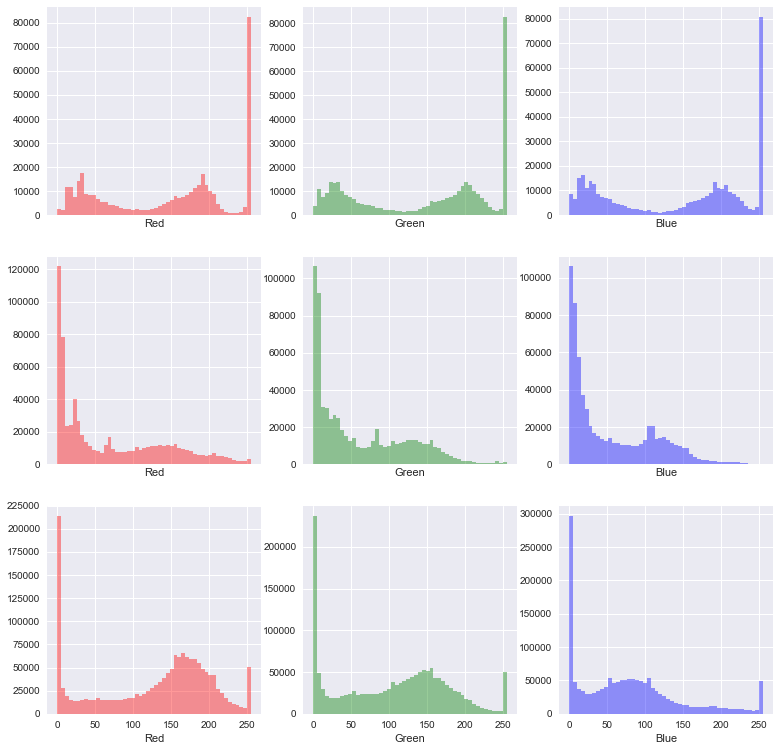

In [299]:
img_count = 5

fig, (ax1, ax2, ax3) = sns.plt.subplots(3, 3, sharex=True)

#fig, axs = sns.plt.subplots(3, 3, sharex=True)
fig.set_size_inches(13, 13)

#ax1.set_ylabel('dda')
r, g, b = get_rgb_values_for_class('data/001.ak47/', img_count)
sns.distplot(r, color='red', kde=False, ax=ax1[0], axlabel='Red')
sns.distplot(g, color='green', kde=False, ax=ax1[1], axlabel='Green')
sns.distplot(b, color='blue', kde=False, ax=ax1[2], axlabel='Blue')

r, g, b = get_rgb_values_for_class('data/007.bat/', img_count)
sns.distplot(r, color='red', kde=False, ax=ax2[0], axlabel='Red')
sns.distplot(g, color='green', kde=False, ax=ax2[1], axlabel='Green')
sns.distplot(b, color='blue', kde=False, ax=ax2[2], axlabel='Blue')

r, g, b = get_rgb_values_for_class('data/025.cactus/', img_count)
sns.distplot(r, color='red', kde=False, ax=ax3[0], axlabel='Red')
sns.distplot(g, color='green', kde=False, ax=ax3[1], axlabel='Green')
sns.distplot(b, color='blue', kde=False, ax=ax3[2], axlabel='Blue')

sns.plt.show()